# **Face Recognition**


**Project Overview**

This project addresses the escalating demand for sophisticated and precise facial recognition systems across diverse domains, including security, attendance management, and user authentication. Leveraging advancements in deep learning techniques, the focus is on elevating the performance of these systems through the implementation of a custom Siamese neural network—a potent architecture renowned for its efficacy in face recognition tasks.

**Data Analysis**

The training dataset utilized for the custom Siamese neural network comprises images of classmates, ensuring diversity in facial expressions, lighting conditions, and angles. This diversity aims to fortify the model's resilience and adaptability in real-world scenarios.

**Data Preprocessing**

To prepare the dataset for training, a comprehensive data preprocessing pipeline was employed. This included resizing, normalization, and other essential transformations performed through a dedicated function to enhance the quality and suitability of the input images.

**Model Development**

The core of the project involved implementing a Siamese neural network, consisting of two identical convolutional neural networks running concurrently. This architecture effectively treats the system as a singular neural network with dual inputs. To optimize the learning process, a custom loss function was devised, leveraging the contrastive loss algorithm.

**Model Evaluation**

The performance evaluation of the model revealed exceptional results, showcasing a remarkable accuracy of 99% on the test set and a perfect 100% accuracy on the training set. Further insights into the model's training progress, including loss and accuracy metrics, are visually represented in the plotted graphs at the conclusion of the notebook.

This project not only contributes to the advancement of facial recognition systems but also underscores the efficacy of the custom Siamese neural network architecture in achieving robust and accurate results.

# Setup and Import Dependencies

In [2]:
import random
import numpy as np
import keras
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
import cv2
import os
import tensorflow as tf
import random
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Hyperparameters

In [3]:
epochs = 10
batch_size = 16
margin = 1  # Margin for contrastive loss.

# Initialize Data Folder

In [4]:
data_folder = '/content/drive/MyDrive/flatiron/cohort_faces/'

- Preprocess the image
- Visualize the images
- Create image pairs
- Load the model
- Predict on new dataset

# Helper Functions
- Preprocessing function
- visualization functions
- create image pairs function

In [5]:
def preprocess_image(image_path, target_size=(256,256)):
    """Preprocesses the given image.

    Arguments:
        image_path: The path to the image file.
        target_size: A tuple of integers indicating the target size.

    Returns:
        A preprocessed image.
    """
    # Step 1: Load the image
    image = cv2.imread(image_path)

    # Step 2: Check if the image was loaded successfully
    if image is None:
        print("Failed to load image:", image_path)
        return None

    # Step 3: Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 4: Resize the grayscale image
    resized_image = cv2.resize(gray_image, target_size)

    # Step 5: Normalize pixel values
    normalized_image = resized_image / 255.0

    return normalized_image

In [6]:
def preprocess_image(image_path, target_size=(256,256), crop_faces=True):
    """Preprocesses the given image.

    Arguments:
        image_path: The path to the image file.
        target_size: A tuple of integers indicating the target size.
        crop_faces: A boolean indicating whether to crop faces from the image.

    Returns:
        A preprocessed image.
    """
    # Step 1: Load the image
    image = cv2.imread(image_path)

    # Step 2: Check if the image was loaded successfully
    if image is None:
        print("Failed to load image:", image_path)
        return None

    # Step 3: Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 4: Crop faces from the image if enabled
    if crop_faces:
        cascPath = '/content/drive/MyDrive/flatiron/haarcascade_frontalface_default.xml'
        faceCascade = cv2.CascadeClassifier(cascPath)
        faces = faceCascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(15,15))
        if len(faces) > 0:
            (x, y, w, h) = faces[0]
            gray_image = gray_image[y:y+h, x:x+w]

    # Step 5: Resize the grayscale image
    resized_image = cv2.resize(gray_image, target_size)

    # Step 6: Normalize pixel values
    normalized_image = resized_image / 255.0

    return normalized_image

In [7]:
def visualize_normalized_image(image):
    # Reshape the flattened image to its original shape
    target_shape = (256,256)  # Replace with the actual target size
    reshaped_image = np.reshape(image, target_shape)

    # Display the normalized image
    plt.imshow(reshaped_image, cmap='gray')
    plt.axis('off')
    plt.show()

In [8]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):
        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

                        # Ensure the pairs are properly formatted
        pair_to_show = np.concatenate([pairs[i][0], pairs[i][1]], axis=0)

        ax.imshow(pair_to_show, cmap="gray")

        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

In [9]:
def create_image_pairs(data_folder, max_pairs_per_person=45):
    person_folders = os.listdir(data_folder)
    image_pairs = []
    labels = []
    total_pairs_created = 0

    # Create an index of image files for each person
    person_images = {}
    for person_folder in person_folders:
        person_path = os.path.join(data_folder, person_folder)
        if not os.path.isdir(person_path):
            continue
        person_images[person_folder] = os.listdir(person_path)

    # Iterate through each person folder
    for person_folder in person_images:
        person_image_files = person_images[person_folder]
        pairs_created_for_person = 0

        # Create positive pairs within the same person folder
        for i in range(len(person_image_files)-1):
            for j in range(i+1, len(person_image_files)):
                if pairs_created_for_person >= max_pairs_per_person:
                    break

                image1_path = os.path.join(data_folder, person_folder, person_image_files[i])
                image2_path = os.path.join(data_folder, person_folder, person_image_files[j])
                preprocessed_image1 = preprocess_image(image1_path)
                preprocessed_image2 = preprocess_image(image2_path)
                if preprocessed_image1 is not None and preprocessed_image2 is not None:
                    image_pairs.append((preprocessed_image1, preprocessed_image2))
                    labels.append(0.0)  # Positive label
                    total_pairs_created += 1
                    pairs_created_for_person += 1

        # Create negative pairs with other person folders
        other_person_folders = [p for p in person_images if p != person_folder]
        for other_person_folder in other_person_folders:
            other_image_files = person_images[other_person_folder]

            for i in range(len(person_image_files)):
                for j in range(len(other_image_files)):
                    if pairs_created_for_person >= max_pairs_per_person:
                        break

                    image1_path = os.path.join(data_folder, person_folder, person_image_files[i])
                    image2_path = os.path.join(data_folder, other_person_folder, other_image_files[j])
                    preprocessed_image1 = preprocess_image(image1_path)
                    preprocessed_image2 = preprocess_image(image2_path)
                    if preprocessed_image1 is not None and preprocessed_image2 is not None:
                        image_pairs.append((preprocessed_image1, preprocessed_image2))
                        labels.append(1.0)  # Negative label
                        total_pairs_created += 1
                        pairs_created_for_person += 1

        print(f"Processed folder: {person_folder}, Pairs created: {pairs_created_for_person}/{max_pairs_per_person}")

    combined = list(zip(image_pairs, labels))
    random.shuffle(combined)
    image_pairs, labels = zip(*combined)

    return image_pairs, labels

# Create Image Pairs


In [62]:
data = create_image_pairs(data_folder)

Processed folder: Ronnie, Pairs created: 45/45
Processed folder: Juan, Pairs created: 45/45
Processed folder: Julie, Pairs created: 45/45
Processed folder: Colby, Pairs created: 45/45
Processed folder: Praveen, Pairs created: 45/45
Processed folder: Sunny, Pairs created: 45/45
Processed folder: Noah, Pairs created: 45/45
Processed folder: John, Pairs created: 45/45
Processed folder: Wesley, Pairs created: 45/45
Processed folder: Ryan, Pairs created: 45/45
Processed folder: Nechama, Pairs created: 45/45


# Save data in a pickle file

so i can load it back in and wont have to run this function again.

In [63]:
pickle.dump(data, open('/content/drive/MyDrive/flatiron/data.pkl', 'wb'))

In [10]:
data = pickle.load(open('/content/drive/MyDrive/flatiron/data.pkl', 'rb'))

In [11]:
image_pairs, labels = data

In [12]:
len(image_pairs)

495

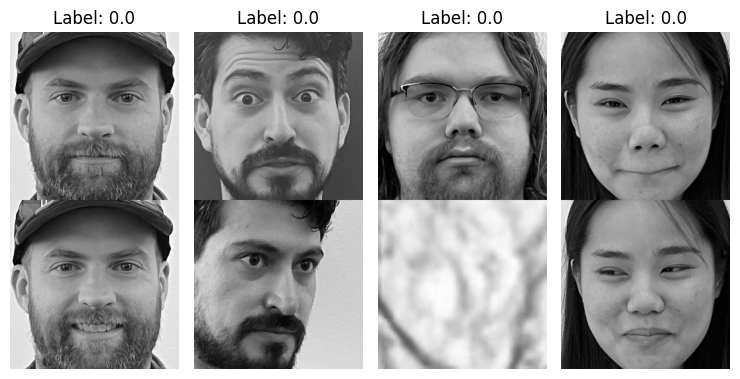

In [13]:
visualize(image_pairs[5:10], labels[5:10], to_show=4, num_col=4)

# Train Test Split

In [14]:
# Convert image_pairs and labels to NumPy arrays
image_pairs = np.array(image_pairs)
labels = np.array(labels)

# Split the data into training and testing sets
x_train_val, x_test, y_train_val, y_test = train_test_split(image_pairs, labels, test_size=0.2, random_state=42)

# Change the data type to a floating point format
x_train_val = x_train_val.astype("float32")
x_test = x_test.astype("float32")

In [15]:
len(x_train_val)

396

In [16]:
# Keep 50% of train_val  in validation set
x_train, x_val = x_train_val[:247], x_train_val[247:]
y_train, y_val = y_train_val[:247], y_train_val[247:]
del x_train_val, y_train_val

In [17]:
x_train_1 = x_train[:, 0]  # x_train_1.shape is (18, 256, 256)
x_train_2 = x_train[:, 1]

x_val_1 = x_val[:, 0]  # x_val_1.shape = (18, 256, 256)
x_val_2 = x_val[:, 1]

x_test_1 = x_test[:, 0]  # x_test_1.shape = (9, 256, 256)
x_test_2 = x_test[:, 1]

In [18]:
x_val_1.shape

(149, 256, 256)

# Define Model

In [79]:
@keras.saving.register_keras_serializable()
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.


    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


input = keras.layers.Input((256, 256, 1))
x = keras.layers.BatchNormalization()(input)
x = keras.layers.Conv2D(4, (5, 5), activation="relu")(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = keras.layers.Conv2D(16, (5, 5), activation="relu")(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(10, activation="relu")(x)
embedding_network = keras.Model(input, x)


input_1 = keras.layers.Input((256, 256, 1))
input_2 = keras.layers.Input((256, 256, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))(
    [tower_1, tower_2]
)
normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

# Define Contrastive Loss

In [19]:
@keras.saving.register_keras_serializable()
def loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    @keras.saving.register_keras_serializable()
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - (y_pred), 0))
        return K.mean((1 - y_true) * square_pred + (y_true) * margin_square)

    return contrastive_loss

# Compile the model with Contrastive Loss Function



In [21]:
siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 model (Functional)          (None, 10)                   835238    ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 1)                    0         ['model[0][0]',         

# Train Model

In [76]:
history = siamese.fit(
    [x_train_1, x_train_2],
    y_train,
    validation_data=([x_val_1, x_val_2], y_val),
    batch_size=batch_size,
    epochs=200,
)

Epoch 1/200
16/16 [==============================] - 32s 2s/step - loss: 0.3265 - accuracy: 0.3239 - val_loss: 0.3052 - val_accuracy: 0.1007
Epoch 2/200
16/16 [==============================] - 27s 2s/step - loss: 0.3102 - accuracy: 0.3239 - val_loss: 0.3412 - val_accuracy: 0.0738
Epoch 3/200
16/16 [==============================] - 29s 2s/step - loss: 0.3004 - accuracy: 0.3441 - val_loss: 0.3798 - val_accuracy: 0.0604
Epoch 4/200
16/16 [==============================] - 30s 2s/step - loss: 0.2864 - accuracy: 0.3684 - val_loss: 0.3690 - val_accuracy: 0.0604
Epoch 5/200
16/16 [==============================] - 29s 2s/step - loss: 0.2747 - accuracy: 0.3927 - val_loss: 0.3517 - val_accuracy: 0.0805
Epoch 6/200
16/16 [==============================] - 29s 2s/step - loss: 0.2633 - accuracy: 0.3968 - val_loss: 0.3273 - val_accuracy: 0.1007
Epoch 7/200
16/16 [==============================] - 29s 2s/step - loss: 0.2519 - accuracy: 0.4494 - val_loss: 0.3059 - val_accuracy: 0.1275
Epoch 8/200
1

# Show and Plot Results

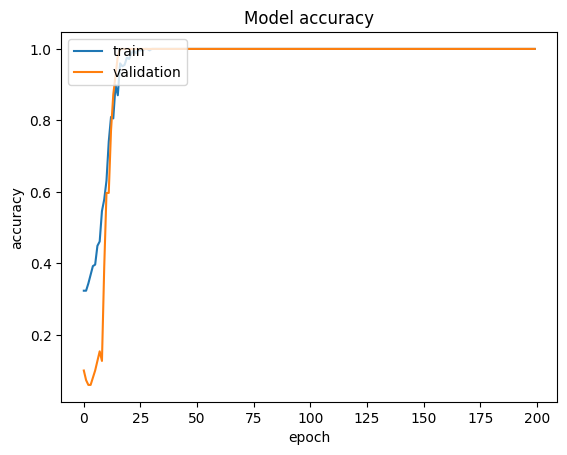

<Figure size 640x480 with 0 Axes>

In [77]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")
plt.savefig('/content/drive/MyDrive/flatiron/p5_models/siamese_accuracy.png')

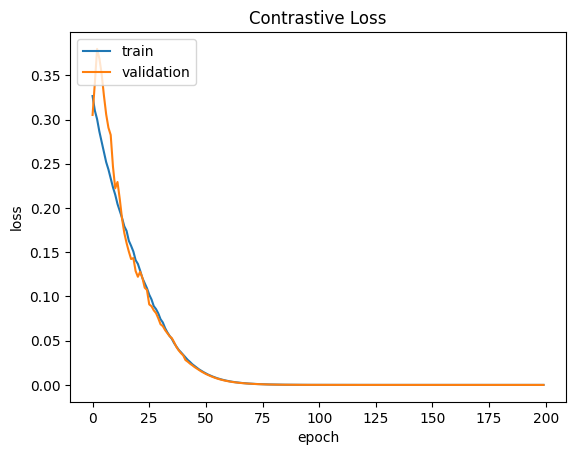

<Figure size 640x480 with 0 Axes>

In [78]:
# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")
plt.savefig('/content/drive/MyDrive/flatiron/p5_models/siamese_loss.png')

In [79]:
results = siamese.evaluate([x_test_1, x_test_2], y_test)
print("test loss, test acc:", results)

4/4 [==============================] - 2s 466ms/step - loss: 4.6062e-06 - accuracy: 1.0000
test loss, test acc: [4.606198672263417e-06, 1.0]


# Save Model

In [80]:
siamese.save('/content/drive/MyDrive/flatiron/p5_models/siamese_model_balanced.keras')
siamese.save('/content/drive/MyDrive/flatiron/p5_models/siamese_model_balanced.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Predictions

4/4 [==============================] - 3s 493ms/step


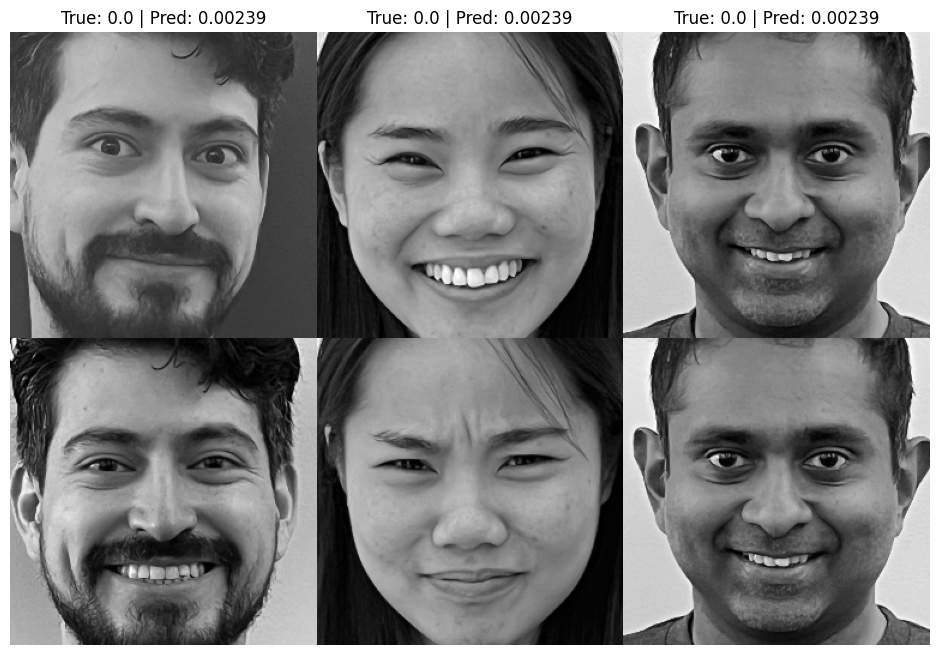

In [24]:
predictions = model.predict([x_test_1, x_test_2])
visualize(x_test, y_test, to_show=4, predictions=predictions, test=True)

# Reload Model
- verify and recognize

In [20]:
model = keras.models.load_model('/content/drive/MyDrive/flatiron/p5_models/siamese_model.keras',
                                safe_mode=False,
                                custom_objects={'contrastive_loss': loss})

# Verification Function

Preprocessing:

The function performs preprocessing on both the input image and validation images. Make sure that the preprocessing steps are consistent with what was used during training the siamese model.

Comparing Shape:

The code checks if the shapes of input_img and validation_img are the same. While this is good for consistency, it might be helpful to log or handle cases where the shapes are different to understand why they might not match.

Result Storage:

The results list stores the model predictions. Ensure that the output shape of the siamese model matches the expected format.
Detection and Verification:

The code calculates the detection as the number of results above a detection_threshold, and then calculates the verification as the ratio of detection to the total number of results. This gives the percentage of images in the verification set that were detected as known faces. The verified variable is then determined based on a verification_threshold. Ensure these threshold values are chosen appropriately based on the characteristics of your model and dataset.

Result Analysis:

The code finds the index with the minimum score (min_score_index) and retrieves the corresponding name from the names list. This is a way to identify the "closest" match in the verification set.


In [53]:
def verify_image(model, detection_threshold, verification_threshold):
    results = []
    names = []

    verification_images_folder = '/content/drive/MyDrive/flatiron/application_data/verification_images'
    for folder in os.listdir(verification_images_folder):
        folder_path = os.path.join(verification_images_folder, folder)
        if not os.path.isdir(folder_path):  # Skip if it's not a directory
            continue
        for image_file in os.listdir(folder_path):
            if image_file.startswith('.'):  # Skip hidden files
                continue
            image_path = os.path.join(folder_path, image_file)
            input_img = preprocess_image('/content/drive/MyDrive/flatiron/application_data/input_image/nechama.jpeg')
            validation_img = preprocess_image(image_path)

            # Check if input_img and validation_img have the same shape
            if input_img.shape != validation_img.shape:
                # Handle the mismatched shape
                continue

            print(f"Input Image Shape: {input_img.shape}")
            print(f"Validation Image Shape: {validation_img.shape}")

            result = model.predict([np.expand_dims(input_img, axis=0), np.expand_dims(validation_img, axis=0)])
            print(f"Prediction Result: {result}")
            results.append(result)
            names.append(os.path.splitext(folder)[0])

    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(results)
    verified = verification > verification_threshold

    min_score_index = np.argmin(results)
    name_with_min_score = names[min_score_index]

    return results, verified, name_with_min_score


# Example usage
results, verified, min_score_name = verify_image(model, 0.5, 0.4)
print(f"Verified: {verified}")
print(f"Welcome {min_score_name}")

Input Image Shape: (256, 256)
Validation Image Shape: (256, 256)
1/1 [==============================] - 0s 84ms/step
Prediction Result: [[0.00238992]]
Input Image Shape: (256, 256)
Validation Image Shape: (256, 256)
1/1 [==============================] - 0s 45ms/step
Prediction Result: [[0.00238992]]
Input Image Shape: (256, 256)
Validation Image Shape: (256, 256)
1/1 [==============================] - 0s 51ms/step
Prediction Result: [[0.00238992]]
Input Image Shape: (256, 256)
Validation Image Shape: (256, 256)
1/1 [==============================] - 0s 44ms/step
Prediction Result: [[0.00238992]]
Input Image Shape: (256, 256)
Validation Image Shape: (256, 256)
1/1 [==============================] - 0s 47ms/step
Prediction Result: [[0.00238992]]
Input Image Shape: (256, 256)
Validation Image Shape: (256, 256)
1/1 [==============================] - 0s 75ms/step
Prediction Result: [[0.00238992]]
Input Image Shape: (256, 256)
Validation Image Shape: (256, 256)
1/1 [========================

KeyboardInterrupt: 

In [30]:
def verify_image(model, detection_threshold, verification_threshold):
    """Returns embeddings and  whether two images are of the same person or different persons."""


    # Build results array
    results = []
    names = []


    for image in os.listdir(os.path.join('/content/drive/MyDrive/flatiron/application_data/verification_images')):
        input_img = preprocess_image('/content/drive/MyDrive/flatiron/application_data/input_image/nechama.jpeg')
        validation_img = preprocess_image(os.path.join('/content/drive/MyDrive/flatiron/application_data/verification_images', image))

        # Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
        names.append(os.path.splitext(image)[0])  # Extracting the name without extension

    # Detection Threshold: Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(results)
    verified = verification > verification_threshold

    # Find the name with the lowest score
    min_score_index = np.argmin(results)
    name_with_min_score = names[min_score_index]

    return results, verified, name_with_min_score

# Example usage:
results, verified, min_score_name = verify_image(model, 0.5, 0.4)
print(f"Verified: {verified}")
print(f"Welcome {min_score_name}")

Failed to load image: /content/drive/MyDrive/flatiron/application_data/verification_images/Colby


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [38]:
results

[array([[0.00238992]], dtype=float32),
 array([[0.00238992]], dtype=float32),
 array([[0.00238992]], dtype=float32),
 array([[0.00238992]], dtype=float32),
 array([[0.00238992]], dtype=float32),
 array([[0.00238992]], dtype=float32),
 array([[0.00238992]], dtype=float32),
 array([[0.00238992]], dtype=float32),
 array([[0.00238992]], dtype=float32),
 array([[0.00238992]], dtype=float32),
 array([[0.00238992]], dtype=float32)]

In [31]:
verify_image(model, detection_threshold = 0.5, verification_threshold = 0.40)

1/1 [==============================] - 0s 19ms/step


([array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32)],
 False,
 'wesley')

In [23]:
y_pred = model.predict([x_test_1, x_test_2])
y_pred.shape

4/4 [==============================] - 4s 66ms/step


(99, 1)

In [24]:
y_test.reshape(-1,1).shape

(99, 1)

8/8 [==============================] - 1s 76ms/step


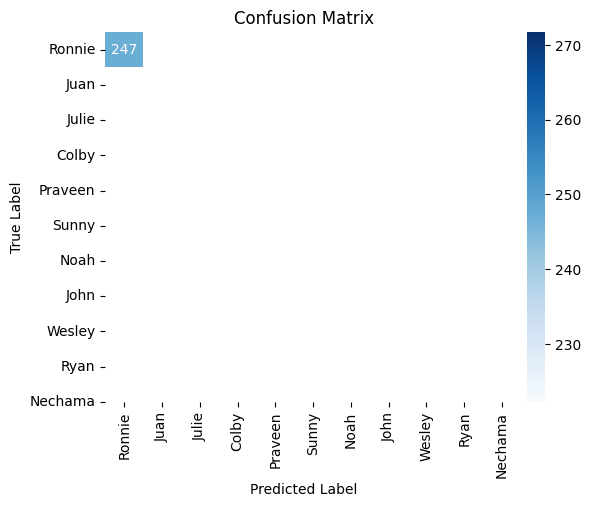

In [30]:
y_true = y_train.reshape(len(y_train), 1)
y_pred = model.predict([x_train_1, x_train_2])  # Replace with your predicted labels

# Convert probability scores to class predictions (argmax)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Replace 'class_names' with your actual class names
class_names =  ['Ronnie', 'Juan', 'Julie', 'Colby', 'Praveen', 'Sunny', 'Noah', 'John', 'Wesley', 'Ryan', 'Nechama']

# Visualize confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
y_true_classes = np.argmax(y_test.reshape(-1, len(y_test)), axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Replace 'class_names' with your actual class names
class_names = ['Ronnie', 'Juan', 'Julie', 'Colby', 'Praveen', 'Sunny', 'Noah', 'John', 'Wesley', 'Ryan', 'Nechama']

# Visualize confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [54]:

print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        99

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99



In [41]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for folder in os.listdir('/content/drive/MyDrive/flatiron/application_data/verification_images'):
        folder_path = os.path.join('/content/drive/MyDrive/flatiron/application_data/verification_images', folder)
        if not os.path.isdir(folder_path):  # Skip if it's not a directory
            continue
        for image_file in os.listdir(folder_path):
            if image_file.startswith('.'):  # Skip hidden files
                continue
            image_path = os.path.join(folder_path, image_file)

            input_img = preprocess_image(os.path.join('/content/drive/MyDrive/flatiron/application_data/input_image', 'nechama.jpeg'))
            validation_img = preprocess_image(image_path)

            # Make Predictions
            result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
            results.append(result)

    # Detection Threshold: Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(results)
    verified = verification > verification_threshold

    return results, verified

In [42]:
verify(model, 0.5, 0.5)

1/1 [==============================] - 0s 20ms/step


KeyboardInterrupt: 

In [50]:
def verify_image(model, detection_threshold, verification_threshold, num_classes):
    results = []
    names = []

    verification_images_folder = '/content/drive/MyDrive/flatiron/application_data/verification_images'
    for folder in os.listdir(verification_images_folder):
        folder_path = os.path.join(verification_images_folder, folder)
        if not os.path.isdir(folder_path):
            continue
        for image_file in os.listdir(folder_path):
            if image_file.startswith('.'):
                continue
            image_path = os.path.join(folder_path, image_file)
            input_img = preprocess_image('/content/drive/MyDrive/flatiron/application_data/input_image/nechama.jpeg')
            validation_img = preprocess_image(image_path)

            # Check if input_img and validation_img have the same shape
            if input_img.shape != validation_img.shape:
                continue

            result = model.predict([np.expand_dims(input_img, axis=0), np.expand_dims(validation_img, axis=0)])
            results.append(result)
            names.append(os.path.splitext(folder)[0])

    # Detection Threshold
    detections = np.array(results)

    # Verification Threshold
    verification = np.max(detections, axis=1)  # Assuming similarity scores; use min for dissimilarity
    verified = np.any(verification >= verification_threshold)

    min_score_index = np.argmin(results)
    name_with_min_score = names[min_score_index]

    return results, verified, name_with_min_score

In [51]:
verify(model, 0.5, 0.5)

1/1 [==============================] - 0s 19ms/step


([array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),
  array([[0.00238992]], dtype=float32),


NameError: name 'name_with_min_score' is not defined